In [1]:
import os
import sys

# append parent directory to path (../notebooks -> ..) this cell should be run once. otherwise it goes one more level up
sys.path.append(os.path.dirname(os.getcwd()))
os.chdir(os.path.dirname(os.getcwd()))

import accelerate
import lovely_tensors as lt
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import scipy.io as io
import torch
import torch.nn as nn
import wandb
import yaml
from diffusers.optimization import get_scheduler
from omegaconf import OmegaConf
from tqdm.auto import tqdm

from ldns.data.monkey import get_monkey_dataloaders
from ldns.networks import AutoEncoder, CountWrapper
from ldns.utils.plotting_utils import *
from ldns.losses import latent_regularizer

# always run from ../ntldm


lt.monkey_patch()
matplotlib.rc_file('matplotlibrc') # mackelab plotting style

%load_ext autoreload
%autoreload 2


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/mnt/conda/envs/ldns/lib/python3.9/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [2]:
cfg_yaml = """
model:
  C_in: 182
  C: 256
  C_latent: 16
  num_blocks: 4
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
  bidirectional: False
dataset:
  system_name: monkey
  task: mc_maze
  datapath: data/000128/sub-Jenkins/
  signal_length: 140
training:
  lr: 0.001
  num_epochs: 260
  num_warmup_epochs: 10
  batch_size: 64
  random_seed: 42
  precision: bf16
  latent_beta: 0.001
  latent_td_beta: 0.2
  tk_k: 5
  mask_prob: 0.5
exp_name: autoencoder-monkey_z=16
"""

# omegaconf from yaml
cfg = OmegaConf.create(yaml.safe_load(cfg_yaml))
print(OmegaConf.to_yaml(cfg))

model:
  C_in: 182
  C: 256
  C_latent: 16
  num_blocks: 4
  num_blocks_decoder: 0
  num_lin_per_mlp: 2
  bidirectional: false
dataset:
  system_name: monkey
  task: mc_maze
  datapath: data/000128/sub-Jenkins/
  signal_length: 140
training:
  lr: 0.001
  num_epochs: 260
  num_warmup_epochs: 10
  batch_size: 64
  random_seed: 42
  precision: bf16
  latent_beta: 0.001
  latent_td_beta: 0.2
  tk_k: 5
  mask_prob: 0.5
exp_name: autoencoder-monkey_z=16



In [3]:
# set seed
torch.manual_seed(cfg.training.random_seed)
np.random.seed(cfg.training.random_seed)

train_dataloader, val_dataloader, test_dataloader = get_monkey_dataloaders(
    cfg.dataset.task, cfg.dataset.datapath, bin_width=5, batch_size=cfg.training.batch_size
)

Task: mc_maze, Bin width: 5 ms
Train: 2581, Val: 71, Test: 216


## Visualise dataset

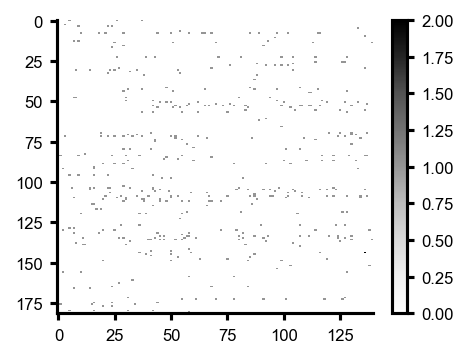

In [4]:

plt.imshow(train_dataloader.dataset[0]['signal'], aspect='auto', cmap='Greys')
plt.colorbar()


## Define model, Optimizer and Learning rate scheduler



In [7]:


ae = AutoEncoder(
    C_in=cfg.model.C_in,
    C=cfg.model.C,
    C_latent=cfg.model.C_latent,
    L=cfg.dataset.signal_length,
    num_blocks=cfg.model.num_blocks,
    num_blocks_decoder=cfg.model.get("num_blocks_decoder", cfg.model.num_blocks),
    num_lin_per_mlp=cfg.model.get("num_lin_per_mlp", 2),  # default 2
    bidirectional=cfg.model.get("bidirectional", True),
)

print("Number of params", sum(p.numel() for p in ae.parameters() if p.requires_grad)/1e6, "M")

ae = CountWrapper(ae)
print(ae)

ae = ae.to(device)
optimizer = torch.optim.AdamW(
    ae.parameters(), lr=cfg.training.lr
)  # default wd=0.01 for now

num_batches = len(train_dataloader)
lr_scheduler = get_scheduler(
    name="cosine",
    optimizer=optimizer,
    num_warmup_steps=num_batches * cfg.training.num_warmup_epochs,  # warmup for 10% of epochs
    num_training_steps=num_batches * cfg.training.num_epochs * 1.1,  # total number of steps for scheduler to go till lr=0
)

# check if signal length is power of 2
if cfg.dataset.signal_length & (cfg.dataset.signal_length - 1) != 0:
    cfg.training.precision = "no"  # torch.fft doesnt support half if L!=2^x


#

# Accelerate setuo

accelerator = accelerate.Accelerator(
    mixed_precision=cfg.training.precision,
    log_with="wandb",
)


(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
) = accelerator.prepare(
    ae,
    optimizer,
    lr_scheduler,
    train_dataloader,
    val_dataloader,
    test_dataloader,
)


cpu
Number of params 1.415366 M
CountWrapper(
  (ae_net): AutoEncoder(
    (encoder_in): Conv1d(182, 256, kernel_size=(1,), stride=(1,))
    (encoder): ModuleList(
      (0-3): 4 x AutoEncoderBlock(
        (time_mixer): FFTConv(
          (activation): Identity()
          (kernel): SSMKernelDPLR()
          (drop): Identity()
          (drop_kernel): Identity()
        )
        (post_tm_scale): Conv1d(256, 256, kernel_size=(1,), stride=(1,), padding=same, groups=256)
        (channel_mixer): Sequential(
          (0): Rearrange('b c l -> b l c')
          (1): Linear(in_features=256, out_features=512, bias=False)
          (2): GELU(approximate='none')
          (3): Linear(in_features=512, out_features=256, bias=False)
          (4): Rearrange('b l c -> b c l')
        )
        (norm1): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (norm2): InstanceNorm1d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        

# set up losses

In [6]:
criterion_poisson = nn.PoissonNLLLoss(log_input=False, full=True, reduction="none")
def compute_val_loss(net, dataloader, do_plot=False):
    net.eval()
    poisson_loss_total = 0
    batch_count = 0

    for batch in dataloader:
        signal = batch["signal"]
        with torch.no_grad():
            output_rates = net(signal)[0].cpu()

        signal = signal.cpu()  # move signal to cpu

        # compute pointwise l2 loss
        poisson_loss = criterion_poisson(output_rates, signal)
        poisson_loss_total += poisson_loss.mean().item()
        batch_count += 1

    # compute average losses over all batches
    avg_poisson_loss = poisson_loss_total / batch_count * cfg.training.mask_prob
    print(f"Validation loss: {avg_poisson_loss:.4f}, mask_prob {cfg.training.mask_prob}")

    if do_plot:
        fig, ax = plt.subplots(2, 1, figsize=(10, 2), dpi=300)
        for row in range(2):  # plot channels 0 and 71, as an example
            ax[row].plot(output_rates[0, 92 * (row)].cpu().clip(0, 3).numpy(), label="pred")
        ax[row].plot(
            batch["signal"][0, 92 * (row)].cpu().clip(0, 3).numpy(),
            label="spikes",
            alpha=0.5,
            color="grey",
        )
        plt.legend()
        
        plt.show()
        plt.close(fig)

    return avg_poisson_loss


In [8]:
# some plotting utils during training (and evaluation)

from ldns.utils.plotting_utils import cm2inch
from einops import rearrange
    
def plot_rate_traces_real(model, dataloader,figsize=(12, 5), idx=0):
    """
    Plot rates and spikes.
    
    Args:
        model: Trained autoencoder model
        dataloader: Data loader
        figsize: Figure size
        idx: Index of the batch to plot
    """
    model.eval()
    for batch in dataloader:
        signal = batch["signal"]
        with torch.no_grad():
            output_rates = model(signal)[0].cpu()

        signal = signal.cpu()  # move signal to cpu
        break

    channels = [136, 8] # as an example
    fig, ax = plt.subplots(len(channels), 1, figsize=cm2inch(figsize), dpi=150)

    for i, channel in enumerate(channels):
        print(batch["signal"][idx, channel])
        L = batch["signal"][idx, channel].shape[0]
        ax[i].vlines(
            torch.arange(L),
            torch.zeros(L),
            torch.ones(L)*output_rates[idx, channel].cpu().max().item(),
            # batch["signal"][0, channel].cpu().numpy(),
            # label="spikes",
            color="black",
            alpha=np.min(
                np.stack(
                    (np.ones(L), batch["signal"][idx, channel].cpu().numpy() * 0.2),
                    axis=1,
                ),
                axis=1,
            ),
        )
        ax[i].plot(output_rates[idx, channel].cpu().numpy(), label="pred", color="red")
        ax[i].set_title(f"channel {channel}")

    ax[-1].legend()

    fig.suptitle("rate traces for channels")
    fig.tight_layout()
    plt.show()


def imshow_rates_real(model, dataloader,figsize=(12, 5), idx=0):
    """
    Plot rates and spikes.
    
    Args:
        model: Trained autoencoder model
        dataloader: Data loader
        figsize: Figure size
        idx: Index of the batch to plot
    """

    model.eval()
    for batch in dataloader:
        signal = batch["signal"]
        with torch.no_grad():
            output_rates = model(signal)[0].cpu()

        signal = signal.cpu()  # move signal to cpu
        break

    fig, ax = plt.subplots(2, 1, figsize=cm2inch(figsize), dpi=150)

    im1 = ax[0].imshow(output_rates[idx].cpu().numpy(), label="rates", aspect='auto', cmap='Greys')
    im2 = ax[1].imshow(signal[idx].cpu().numpy(), label="rates", aspect='auto', cmap='Greys')
    plt.colorbar(im1, ax=ax[0])
    plt.colorbar(im2, ax=ax[1])
    plt.show()

    # ax.set_title(f"channel {channel}")

    ax[-1].legend()

    fig.suptitle(f"infeered rates, idx {idx}")
    fig.tight_layout()
    plt.show()



## training loop

In [ ]:
# training loop with validation
# tracks reconstruction loss, latent regularization, and validation metrics

rec_losses, latent_losses, total_losses, lrs, val_rate_losses = [], [], [], [], []
avg_poisson_loss, avg_rate_loss = 0, 0

# flags for enabling/disabling different evaluations, enable what you want
do_val_loss = True  # compute validation loss every 10 epochs
do_val_plots = False  # generate validation plots every 20 epochs

# lists to store losses for plotting
train_losses = []
val_losses = []

with tqdm(range(0, cfg.training.num_epochs)) as pbar:
    for epoch in pbar:
        ae.train()
        epoch_losses = []

        for i, data in enumerate(train_dataloader):
            optimizer.zero_grad()
            signal = data["signal"]

            # coordinated dropout masking
            # randomly mask out some inputs and scale remaining ones
            mask_prob = cfg.training.get("mask_prob", 0.5) # if not specified, mask out half of the inputs
            mask = (torch.rand_like(signal) > mask_prob).float()  
            input_signal = signal * (mask / (1 - mask_prob))  # scale unmasked values

            # forward pass
            output_rates, z = ae(input_signal)
            numel = signal.shape[0] * signal.shape[1] * signal.shape[2]

            # compute losses
            unmasked = (1 - mask) if mask_prob > 0 else torch.ones_like(mask)
            poisson_loss = criterion_poisson(output_rates, signal) * unmasked
            poisson_loss = poisson_loss.mean()
            rec_loss = poisson_loss

            # add latent regularization
            latent_loss = latent_regularizer(z, cfg) / numel
            loss = rec_loss + cfg.training.latent_beta * latent_loss

            # optimization step
            accelerator.backward(loss)
            accelerator.clip_grad_norm_(ae.parameters(), 2.0)
            optimizer.step()
            lr_scheduler.step()

            # logging
            pbar.set_postfix(
                **{
                    "rec_loss": rec_loss.item(),
                    "latent_loss": latent_loss.item(), 
                    "total_loss": loss.item(),
                    "lr": optimizer.param_groups[0]["lr"],
                    "val_poisson_loss": avg_poisson_loss,
                }
            )

            # store metrics
            rec_losses.append(rec_loss.item())
            latent_losses.append(latent_loss.item())
            total_losses.append(loss.item())
            lrs.append(optimizer.param_groups[0]["lr"])
            epoch_losses.append(loss.item())

        # store average training loss for this epoch
        train_losses.append(np.mean(epoch_losses))

        # validation and checkpointing
        if accelerator.is_main_process:
            # compute validation loss every 10 epochs
            if do_val_loss and ((epoch + 1) % 10 == 0 or epoch == cfg.training.num_epochs - 1):
                avg_poisson_loss = compute_val_loss(ae, val_dataloader)
                val_losses.append(avg_poisson_loss)

            # generate plots and save model every 20 epochs
            if (epoch + 1) % 20 == 0 or epoch == cfg.training.num_epochs - 1:
                ae.eval()
                
                # plot training curves
                plt.figure(figsize=cm2inch(6, 4))
                plt.plot(train_losses, label='train loss')
                plt.plot(np.arange(9, len(val_losses)*10, 10), val_losses, label='val loss')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.yscale('log')
                plt.legend()
                plt.title('training and validation losses')
                plt.show()
                
                # generate validation plots
                if do_val_plots:
                    plot_rate_traces_real(ae, val_dataloader, figsize=(6, 6), idx=1)
                    imshow_rates_real(ae, val_dataloader, figsize=(6, 3), idx=1)
                
                # save checkpoint
                accelerator.save_state(f"exp/{cfg.exp_name}/epoch_{(epoch+20)//20*20}")

In [ ]:
# at the end, save the final model
torch.save(ae.state_dict(), f"exp/{cfg.exp_name}/model.pt")

To train the diffusion model, use the `train_diffusion_monkey.ipynb` notebook, where this trained autoencoder is used.
